In [1]:
# 必要なライブラリをインポートします
import torch  # PyTorchの主要ライブラリ
import torch.nn as nn  # ニューラルネットワークモジュール
import torch.optim as optim  # 最適化アルゴリズム
from torch.utils.data import DataLoader  # データローダー
from torchvision import datasets, transforms  # 画像データセットと変換
from timm.models.swin_transformer import SwinTransformer  # Swin Transformerモデル
import matplotlib.pyplot as plt  # グラフ描画ライブラリ
from ipywidgets import IntProgress  # プログレスバーウィジェット
from IPython.display import display  # IPython表示機能

In [2]:
# CUDA が利用可能か確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ハイパーパラメータを設定します
batch_size = 64  # バッチサイズ：一度に処理するデータ数
learning_rate = 0.001  # 学習率：最適化の歩幅
num_epochs = 10  # エポック数：全データセットを何回学習するか

In [4]:
# データの前処理を定義します
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # 画像を32x32にリサイズ
        transforms.ToTensor(),  # 画像をテンソルに変換
        transforms.Normalize(
            (0.1307,), (0.3081,)
        ),  # MNISTデータセットの平均と標準偏差で正規化
    ]
)

In [5]:
# MNISTデータセットの読み込み
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# Swin Transformerモデルを定義します
class SwinTransformerForMNIST(nn.Module):
    def __init__(self):
        super(SwinTransformerForMNIST, self).__init__()
        self.swin = SwinTransformer(
            img_size=32,  # 入力画像サイズ
            patch_size=2,  # パッチサイズ
            in_chans=1,  # 入力チャンネル数（グレースケール）
            num_classes=10,  # 出力クラス数（0-9の数字）
            embed_dim=32,  # 埋め込みベクトルの次元
            depths=[2, 2, 2],  # 各段階のTransformerブロック数
            num_heads=[2, 4, 8],  # 各段階のアテンションヘッド数
            window_size=4,  # ウィンドウサイズ
            mlp_ratio=2.0,  # MLPの拡大率
            qkv_bias=True,  # クエリ、キー、バリューにバイアスを使用
            drop_rate=0.1,  # ドロップアウト率
            attn_drop_rate=0.1,  # アテンションのドロップアウト率
            drop_path_rate=0.1,  # パスのドロップアウト率
        )

    def forward(self, x):
        return self.swin(x)  # モデルの順伝播

In [7]:
# モデル、損失関数、オプティマイザを初期化します
model = SwinTransformerForMNIST().to(device)
criterion = nn.CrossEntropyLoss()  # 多クラス分類のための交差エントロピー損失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adamオプティマイザ

In [8]:
# 訓練関数を定義します
def train(epoch):
    model.train()  # モデルを訓練モードに設定
    train_loss = 0
    correct = 0
    total = 0
    progress = IntProgress(min=0, max=len(train_loader))
    display(progress)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # データをGPUに移動
        optimizer.zero_grad()  # 勾配をゼロに初期化
        output = model(data)  # モデルの出力を計算
        loss = criterion(output, target)  # 損失を計算
        loss.backward()  # 逆伝播で勾配を計算
        optimizer.step()  # パラメータを更新

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress.value += 1

    return train_loss / len(train_loader), 100.0 * correct / total

In [9]:
# テスト関数を定義します
def test():
    model.eval()  # モデルを評価モードに設定
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # 勾配計算を無効化
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_loader), 100.0 * correct / total

In [10]:
# 訓練ループ
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    print(f"エポック {epoch}/{num_epochs}")
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"訓練損失: {train_loss:.4f}, 訓練精度: {train_acc:.2f}%")
    print(f"テスト損失: {test_loss:.4f}, テスト精度: {test_acc:.2f}%")

エポック 1/10


IntProgress(value=0, max=938)

訓練損失: 0.6476, 訓練精度: 78.63%
テスト損失: 0.1960, テスト精度: 93.94%
エポック 2/10


IntProgress(value=0, max=938)

訓練損失: 0.1962, 訓練精度: 94.13%
テスト損失: 0.1366, テスト精度: 95.70%
エポック 3/10


IntProgress(value=0, max=938)

訓練損失: 0.1458, 訓練精度: 95.54%
テスト損失: 0.0896, テスト精度: 97.07%
エポック 4/10


IntProgress(value=0, max=938)

訓練損失: 0.1183, 訓練精度: 96.31%
テスト損失: 0.0912, テスト精度: 97.16%
エポック 5/10


IntProgress(value=0, max=938)

訓練損失: 0.1020, 訓練精度: 96.88%
テスト損失: 0.0659, テスト精度: 98.02%
エポック 6/10


IntProgress(value=0, max=938)

訓練損失: 0.0906, 訓練精度: 97.22%
テスト損失: 0.0651, テスト精度: 98.10%
エポック 7/10


IntProgress(value=0, max=938)

訓練損失: 0.0784, 訓練精度: 97.61%
テスト損失: 0.0666, テスト精度: 98.00%
エポック 8/10


IntProgress(value=0, max=938)

訓練損失: 0.0747, 訓練精度: 97.72%
テスト損失: 0.0535, テスト精度: 98.25%
エポック 9/10


IntProgress(value=0, max=938)

訓練損失: 0.0679, 訓練精度: 97.88%
テスト損失: 0.0468, テスト精度: 98.47%
エポック 10/10


IntProgress(value=0, max=938)

訓練損失: 0.0612, 訓練精度: 98.09%
テスト損失: 0.0466, テスト精度: 98.53%


In [11]:
# モデルを保存します
torch.save(model.state_dict(), 'swin_transformer_mnist.pth')
print("モデルを'swin_transformer_mnist.pth'として保存しました")

モデルを'swin_transformer_mnist.pth'として保存しました


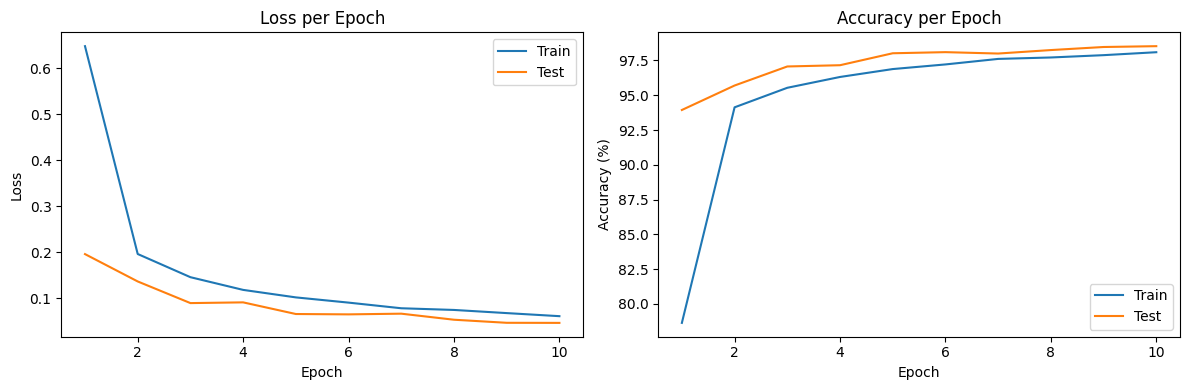

In [13]:
# 結果をプロットします
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy per Epoch")

plt.tight_layout()
plt.show()